# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import math
from sklearn.metrics import f1_score

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [104]:
# Show info of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


Column 'article_id' in df is of type float.

In [105]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [106]:
# Show info of df_content
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


Column 'article_id' in df_content is of type int.

In [107]:
# Shape of df(user_item_interactions)
df.shape

(45993, 3)

In [108]:
# Finding missing values in df
df.isnull().any()

article_id    False
title         False
email          True
dtype: bool

So, there are missing values in column email in df(user_item_interactions).

In [109]:
# Print number of missing values in df
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

So, there are 17 missing values in column email in df.

In [110]:
# Shape of df_content
df_content.shape

(1056, 5)

In [111]:
# Finding missing values in df_content
df_content.isnull().any()

doc_body            True
doc_description     True
doc_full_name      False
doc_status         False
article_id         False
dtype: bool

So, there are missing values in columns doc_body and doc_description in df_content.

In [112]:
# Print number of missing values in df_content
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

So, there are 14 missing values in column doc_body and 3 missing values in column doc_description.

In [113]:
# find duplicates in df
df.duplicated().value_counts()

False    33682
True     12311
dtype: int64

So, there are 12311 duplicates in df.

In [114]:
# find duplicates in df_content
df_content.duplicated().value_counts()

False    1056
dtype: int64

So, there are no duplicates in df_content.

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [115]:
# Group df by email and check article_id's count
df.groupby('email')['article_id'].value_counts()

email                                     article_id
0000b6387a0366322d7fbfc6434af145adf7fed1  43.0          2
                                          124.0         1
                                          173.0         1
                                          288.0         1
                                          349.0         1
                                          618.0         1
                                          732.0         1
                                          1162.0        1
                                          1232.0        1
                                          1314.0        1
                                          1337.0        1
                                          1354.0        1
001055fc0bb67f71e8fa17002342b256a30254cd  124.0         1
                                          254.0         1
                                          390.0         1
                                          1386.0        1
00148e4911c7e04eeff

In [116]:
# Get number of user_item inetractions for each user
df.groupby('email')['article_id'].count()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
0042719415c4fca7d30bd2d4e9d17c5fc570de13     2
00772abe2d0b269b2336fc27f0f4d7cb1d2b65d7     3
008ba1d5b4ebf54babf516a2d5aa43e184865da5    10
008ca24b82c41d513b3799d09ae276d37f92ce72     1
008dfc7a327b5186244caec48e0ab61610a0c660    13
009af4e0537378bf8e8caf0ad0e2994f954d822e     1
00bda305223d05f6df5d77de41abd2a0c7d895fe     4
00c2d5190e8c6b821b0e3848bf56f6e47e428994     3
00ced21f957bbcee5edf7b107b2bd05628b04774     4
00d9337ecd5f70fba1c4c7a78e21b3532e0112c4     3
00e524e4f13137a6fac54f9c71d7769c6507ecde    11
00f8341cbecd6af00ba8c78b3bb6ec49adf83248     3
00f946b14100f0605fa25089437ee9486378872c     1
01041260c97ab9221d923b0a2c525437f148d589     2
0108ce3220657a9a89a85bdec959b0f2976dd51c     4
011455e91a24c1fb815a4deac6b6eaf5ad16819e     9
01198c5

In [117]:
# How many unique users have interacted with articles
len(df.groupby('email'))

5148

In [118]:
# Distribution of user_item interactions
df.groupby('email')['article_id'].count().values

array([13,  4,  3, ..., 32, 10, 13])

In [119]:
# Getting counts of distribution of article intreactions
df.groupby('email')['article_id'].count().value_counts().sort_index()

1      1416
2       694
3       485
4       351
5       277
6       228
7       182
8       156
9       115
10      124
11      106
12       80
13       71
14       58
15       45
16       48
17       34
18       42
19       34
20       41
21       30
22       27
23       25
24       24
25       27
26       23
27       13
28       24
29       19
30       21
       ... 
89        2
91        2
92        1
94        2
95        2
96        1
97        1
98        1
101       2
102       2
103       1
104       1
114       1
116       1
131       1
132       1
136       1
137       1
140       1
142       1
144       1
145       2
147       2
148       1
158       1
160       1
169       1
170       1
363       1
364       1
Name: article_id, Length: 114, dtype: int64

In [120]:
# Get info about the distribution of user_item interactions
df.groupby('email')['article_id'].count().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

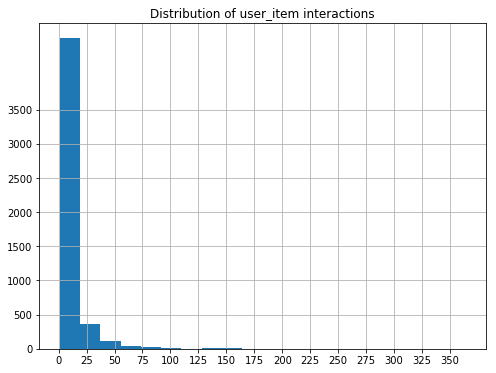

In [121]:
# Plotting histogram of distribution of user_item interactions
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(df.groupby('email')['article_id'].count().values, bins=20, range=(1,364))
ax.set_xticks(np.arange(0,364,25))
ax.set_yticks(np.arange(0,4000, 500))
ax.set_title('Distribution of user_item interactions')
ax.grid(which='major', axis='y')
ax.grid(which='major', axis='x')
plt.show();

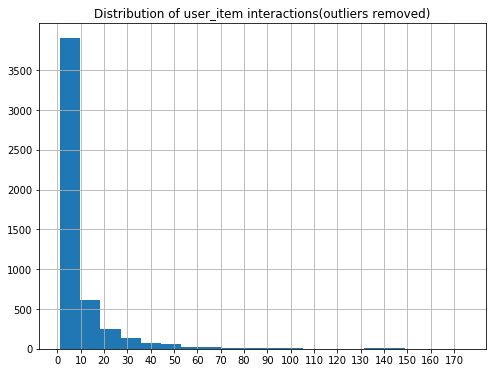

In [122]:
# Plotting histogram of distribution of user_item interactions(outliers removed) i.e.
# removed values with 363 & 364 number of interactions as there were only 1 user whom had 363 & 364 number of interactions
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(df.groupby('email')['article_id'].count().values, bins=20, range=(1,175))
ax.set_xticks(np.arange(0,175,10))
ax.set_yticks(np.arange(0,4000, 500))
ax.set_title('Distribution of user_item interactions(outliers removed)')
ax.grid(which='major', axis='y')
ax.grid(which='major', axis='x')
plt.show();

In [123]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [124]:
# Find and explore duplicate entries in df_content
df_content.duplicated().sum()

0

In [125]:
# Find and explore duplicate articles in df_content
df_content['article_id'].duplicated().sum()

5

There are no duplicate entries in df_content but there are 5 duplicate articles in df_content.

In [126]:
# Get duplicate articles ID's in df_content
print('Number of duplicate articles are : {}'.format(df_content['article_id'].duplicated().sum()))
print("Duplicate articles ID's are : {}".format(df_content[df_content['article_id'].duplicated()]['article_id'].values))

Number of duplicate articles are : 5
Duplicate articles ID's are : [ 50 221 398 577 232]


In [127]:
# Get observations with duplicate articles ID's
dup_article_id = df_content[df_content['article_id'].duplicated()]['article_id'].values.tolist()
df_content.loc[np.where(df_content['article_id'].isin(dup_article_id))[0]]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [128]:
# Get duplicate articles entries
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [129]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [130]:
# Shape of df and unique values in each of column of df
print(df.shape)
print(df.nunique())

(45993, 3)
article_id     714
title          714
email         5148
dtype: int64


In [131]:
# a. The number of unique articles that have an interaction with a user.
df['article_id'].nunique()

714

In [132]:
# b. The number of unique articles in the dataset (whether they have any interactions or not).
df_content['article_id'].nunique()

1051

In [133]:
# Check null values in column email of df
df['email'].isnull().value_counts()

False    45976
True        17
Name: email, dtype: int64

So, there are 17 observatiosn which has null values in column email.

In [134]:
# c. The number of unique users in the dataset. (excluding null values)
df[~df['email'].isnull()]['email'].nunique()

5148

In [135]:
# d. The number of user-article interactions in the dataset
df.shape

(45993, 3)

In [136]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [137]:
# Find the most viewed article_id, as well as how often it was viewed
df.groupby('article_id')['email'].count().sort_values(ascending=False).head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [138]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [139]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [140]:
# Number of unique user id's in df
# null value in column email was also assigned a unique user id
df['user_id'].nunique()

5149

In [141]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [142]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    n_top_articles_title = []
    for article_id in get_top_article_ids(n, df):
        n_top_articles_title.append(df[df['article_id'] == float(article_id)]['title'][:1].values[0])
        
    return n_top_articles_title # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    n_top_articles_ids - (list of str) A list of the top 'n' article ids 
    
    '''
    # Your code here
    n_top_articles_ids = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).index[:n].tolist()
    
    # Convert all elements of list(float) to list(str)
    for i in range(len(n_top_articles_ids)):
        n_top_articles_ids[i] = str(n_top_articles_ids[i])
               
    return n_top_articles_ids # Return the top article ids

In [143]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [144]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [145]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id','article_id'])['article_id'].count().unstack()
    
    for col in user_item.columns:
        user_item[col] = user_item[col].apply(lambda x: 0 if math.isnan(float(x)) else 1)  
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [146]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [148]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # Calculate similarity of provided user with all other users
    similarity_users = user_item.loc[user_id,:].dot(np.transpose(user_item))

    # sort by similarity
    similarity_users_sorted = similarity_users.sort_values(ascending=False)

    # create list of just the ids
    similar_ids_list = similarity_users_sorted.index.tolist()
   
    # remove the own user's id
    similar_ids_list.remove(user_id)
    most_similar_users = similar_ids_list
       
    return most_similar_users # return a list of the users in order from most to least similar

In [149]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [150]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list of str) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    for a_id in article_ids:
        article_names.append(df[df['article_id'] == float(a_id)]['title'][:1].values[0])
        
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list of str) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id, user_item.loc[user_id,:] == 1].index.tolist()
    
    for i in range(len(article_ids)):
        article_ids[i] = str(article_ids[i])
        
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = np.array([])
    
    # articles_seen by user (we don't want to recommend these)
    article_ids, article_names = get_user_articles(user_id)
    
    # Similar users to provided user
    similar_users = find_similar_users(user_id)
    
    for sim_user in similar_users:
        sim_user_article_ids, sim_user_article_names = get_user_articles(sim_user)
        
        #Obtain recommendations for each similar user
        new_recs = np.setdiff1d(np.array(sim_user_article_ids), np.array(article_ids), assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) >= m:
            break
            
    recs = recs.tolist()
    recs = recs[:m]
    
          
    return recs # return your recommendations for this user_id

In [151]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [152]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [153]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # Compute similarity of each user to the provided user
    similarity_users = user_item.loc[user_id,:].dot(np.transpose(user_item))

    # Create neighbors_df
    neighbors_df = similarity_users.reset_index().rename(columns={'user_id':'neighbor_id', user_id:'similarity'})
    
    # Compute num_interactions for each neighbor_id and create another dataframe num_interactions_df
    num_interactions_df = df.groupby('user_id')['article_id'].count().reset_index()
    num_interactions_df = num_interactions_df.rename(columns={'article_id':'num_interactions'}).drop(columns=['user_id'])
    
    # Join two dataframes (neighbors_df & num_interactions_df)
    neighbors_df = neighbors_df.join(num_interactions_df)
   
    # remove the own user's id and sort by similarity
    idx = neighbors_df[neighbors_df['neighbor_id'] == user_id].index
    neighbors_df.drop(index=idx,inplace=True)
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Your code here
    recs = []
    rec_names = []
    
    try:
        # articles alread read by user (we don't want to recommend these)
        article_ids, article_names = get_user_articles(user_id)
    except KeyError: #user does not exist
        print('User does not exist, Recommending Top Articles')
        recs = get_top_article_ids(m)
        rec_names = get_top_articles(m)
        return recs, rec_names
    
    # Create user_article_df and compute interactions_count of each article
    dict_1 = {'article_id': article_ids, 'article_name': article_names}
    user_article_df = pd.DataFrame(dict_1)
    user_article_df['art_inter_count'] = user_article_df['article_id'].apply(lambda x:\
                                                                              df[df['article_id'] == float(x)]\
                                                                              ['user_id'].count())
    
    # Sort user_article_df by interactions_count of each article 
    user_article_df.sort_values(by=['art_inter_count'], ascending=False, inplace=True)
    
    # Get sorted article id's for provided user
    article_ids_sorted = user_article_df['article_id'].astype(float).values
  
    # Similar users to provided user by using new function get_top_sorted_users() 
    similar_users = get_top_sorted_users(user_id)['neighbor_id'].values.tolist()
    
    for sim_user in similar_users:
        sim_user_article_ids, sim_user_article_names = get_user_articles(sim_user)
        
        # Compute interactions_count of each article for similar user
        
        # Create another dataframe sim_user_article_df and compute article interactions count for similar user
        dict_2 = {'sim_user_article_id': sim_user_article_ids,
                  'sim_user_article_name': sim_user_article_names}
        
        sim_user_article_df = pd.DataFrame(dict_2)
        sim_user_article_df['sim_user_art_inter_count'] = sim_user_article_df['sim_user_article_id'].\
                                                                            apply(lambda x: df[df['article_id'] == float(x)]\
                                                                                  ['user_id'].count())
        
        # Sort sim_user_article_df by interactions_count of each article 
        sim_user_article_df.sort_values(by=['sim_user_art_inter_count'], ascending=False, inplace=True)
    
        # Get sorted article id's for similar user
        sim_user_article_ids_sorted = sim_user_article_df['sim_user_article_id'].astype(float).values

        #Obtain recommendations for each similar user
        new_recs = np.setdiff1d(np.array(sim_user_article_ids_sorted), np.array(article_ids_sorted), assume_unique=True)

        # Update recs with new recs
        for ele in new_recs:
            if str(ele) not in recs:
                recs.append(str(ele))

        # If we have enough recommendations exit the loop
        if len(recs) >= m:
            break
    
    recs = recs[:m]
    
    rec_names = get_article_names(recs)

    
    return recs, rec_names

In [154]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [155]:
# Find the user that is most similar to user 1 
find_similar_users(1)[0]

3933

In [156]:
# Find the 10th most similar user to user 131
find_similar_users(131)[9]

242

In [157]:
### Tests with a dictionary of results
user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [158]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**1. For a new user, we would not be able to use any recommendation method that relies on user similarity. Since the new user has most likely not read any articles yet, we cannot generate a similarity metric for the new user. Such kind of problem is known as Cold Start problem. Therefore, we cannot make recommendations to a new user using Collaborative filtering. Instead, we can use techniques like rank based recommendations for new users which means we would recommend new users with the most popular articles.**

**2. The downside of this approach is that it could potentially skew our recommendation algorithm later on as it would consider new users who have interacted with all the same articles to be similar, but this would only be because they were suggested the same articles to begin with using ranked based recommendation method.**

**3. Also considering article popularity based on the number of interactions presents the challenge that articles that are recommended in the new user scenario are likely to get more hits, wich would further increase their chances of being shown to the next new user.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [57]:
# Getting recommendation for new user '0.0' which does not exist
# Here, we had made sure that in case of Cold Start problem when using collaborative filtering,
# we provide recommendations with the help of rank based recommendation method
user_user_recs_part2('0.0')

User does not exist, Recommending Top Articles


(['1429.0',
  '1330.0',
  '1431.0',
  '1427.0',
  '1364.0',
  '1314.0',
  '1293.0',
  '1170.0',
  '1162.0',
  '1304.0'],
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model'])

In [58]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here
set(new_user_recs)

{'1162.0',
 '1170.0',
 '1293.0',
 '1304.0',
 '1314.0',
 '1330.0',
 '1364.0',
 '1427.0',
 '1429.0',
 '1431.0'}

In [59]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [60]:
# import libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [61]:
# Define function tokenize to normalize, tokenize and lemmatize text string
def tokenize(text):
    """Normalize, tokenize and lemmatize text string
    
    Args:
    text: string, String containing text for processing
       
    Returns:
    clean_tokens: list, List containing normalized and lemmatized word tokens
    """

    # Replace URL links in text string with string 'urlplaceholder'
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    
    # Substitute characters in text string which match regular expression r'[^a-zA-Z0-9]'
    # with single whitespace
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # Get word tokens from text string
    tokens = word_tokenize(text)
    
    # Instantiate WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Get stop words in 'English' language
    stop_words = stopwords.words("english")

    # Clean tokens
    clean_tokens = []
    for tok in tokens:
        # convert token to lowercase as stop words are in lowercase
        tok_low = tok.lower() 
        if tok_low not in stop_words:
            # Lemmatize token and remove the leading and trailing spaces from lemmatized token
            clean_tok = lemmatizer.lemmatize(tok_low).lower().strip()
            clean_tokens.append(clean_tok)

    return clean_tokens

In [62]:
def make_content_recs(_id, _id_type='user', m=10, df=df):
    '''
    INPUT:
        _id (str) - either a user_id or article_id
        _id_type (str)- "user" or "article"
        m (int) - number of recommendations to return
    OUTPUT:
        recs (list of str) - list of article ids that are recommended
        rec_names (list) - list of article names that are recommended
        
    Description:
       This content based recommender looks at the articles that the user has interacted with.
       It goes through each article title and use the NLTK library, finds the most common words
       (related to content) throughout all the articles.
              
       Based on these most common words, the recommender looks at the sums of words in
       the title of each article, and based on the number of matches as well as the
       general popularity of the article it gives back the best recommendations.
    '''
    
    recs, rec_names = None, None
    if _id_type == 'user':
        user_id = _id
        try:
            #get already read articles
            article_ids, _ = get_user_articles(int(float(user_id)))
        except KeyError: #user does not exist
            print('User does not exist, Recommending Top Articles')
            recs = get_top_article_ids(m)
            rec_names = get_article_names(recs)
            return recs, rec_names
        
    elif _id_type == 'article':
        a_id = str(_id)
        #Check if article exists in df
        if a_id in df['article_id'].values.astype(str).tolist():
            article_ids = []
            article_ids.append(a_id)                                 
        else: #user does not exist
            print('Article does not exist, Recommending Top Articles')
            recs = get_top_article_ids(m)
            rec_names = get_article_names(recs)
            return recs, rec_names
        
    else:
        print("Please enter _id_type_ correctly. id_type must be 'user' or 'article'")
        return recs, rec_names
                                               
    # Create dataframe df_title without any duplicates of 'article_id' which would give unique titles
    df_title = df.drop_duplicates(subset=['article_id'], keep='first').sort_values(by=['article_id']).reset_index()
    df_title.drop(columns=['index'], inplace=True)
    titles = df_title[df_title['article_id'].isin(np.array(article_ids, dtype=float))]['title']
    
    #tokenize the text in each article title
    tokens_list = tokenize(titles.str.cat(sep=' '))
    
    #find the top occuring words
    top_words = pd.value_counts(tokens_list).sort_values(ascending=False)[:10].index.tolist()
    
    # Count number of occurences of each top word in all article titles (this measures similarity)
    word_matches_dict={}
    for word in top_words:
        word_count = pd.Series(df_title['title'].str.count(word).fillna(0)) #get occurences of each word in title
        word_matches_dict[word] = word_count
     
    # Create dataframe df_top_words with dict word_matches_dict
    df_top_words = pd.DataFrame(word_matches_dict) # num_cols == num of most common words(which can be atmost 10)
    df_top_words['total_matches'] = df_top_words.sum(axis=1)
    df_top_words['article_id'] = df_title['article_id']
    
    # Get article interactions count and create another dataframe df_art_int
    art_inter_count = df.groupby('article_id')['user_id'].count()
    df_art_int = pd.DataFrame({'art_inter_count': art_inter_count}).reset_index()

    # Merging two dataframes df_top_words & df_art_int 
    df_top_words = df_top_words.merge(df_art_int, on='article_id')
    
    # Sort df_top_words by total_matches & article interactions count
    df_top_words.sort_values(by = ['total_matches', 'art_inter_count'], ascending=False, inplace=True)
    
    #drop already read articles
    df_recs = df_top_words[~df_top_words['article_id'].isin(np.array(article_ids, dtype=float))]
    
    # Get recs and rec_names
    recs = df_recs['article_id'][:m].values.astype(str).tolist()
    rec_names = get_article_names(recs)
    
    return recs, rec_names

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

In [63]:
# Number of unique articles in df
df['article_id'].nunique()

714

In [64]:
# Number of unique articles in df_content
df_content['article_id'].nunique()

1051

In [65]:
# Find common articles in df & df_content
art_df_set = set(df['article_id'].values.astype(int).tolist())
art_df_content_set = set(df_content['article_id'].values.astype(int).tolist())
len(art_df_set.intersection(art_df_content_set))

437

In [66]:
# Find number of unique articles which got interacted(were in df) but were not in df_content
df['article_id'].nunique() - len(art_df_set.intersection(art_df_content_set))

277

In [67]:
# Find number of unique articles which were in df_content but didn't got interacted i.e. were not in df
df_content['article_id'].nunique() - len(art_df_set.intersection(art_df_content_set))

614

**This content based recommender looks at the articles the user has interacted with. It goes through each article title and using the NLTK library finds the most common words in the titles of each article that the user has interacted with.**

**Based on these most common words, the recommender looks at all the articles which had interaction with atleast one user, looks at the words in the title of each article, find the frequency of occurence of each common words and compute the total count by summing up the frequencies of each common word in each article title, and based on the number of matches i.e. total count of common words in the titles as well as the general popularity of the article it gives back the best recommendations.**

**If the user has not read any articles yet i.e. for a new user, then we can't really give any content based recommendations, and recommender just return back some of the most popular articles using ranked based recommendation method.**

**There is a lot of potential improvement and optimization for this recommender. For example, one could construct a custom NLTK corpus which would filter out article words. Currently, I used a standard NLTK corpora.**

**Currently, we had used only articles which got interacted and used titles from those articles in df, there were 714 unique articles in df which had got interacted. Out of 714, only 437 articles were common to df & df_content which meant that there were 277 articles in df which had got interacted but were not in df_content. This also meant, there was no information about(doc_body, doc_description & doc_full_name) for those 277 articles in df_content. Also, there were 614 unique articles which were in df_content but never got interacted i.e. were not in df. Therefore, 217 unique articles in df missed information in df_content and 614 unique articles in df_content missed information in df.**

**We could have our recommender to look for more text information in columns 'doc_body', 'doc_description' & 'doc_full_name' in df_content apart from looking text information in column 'title' in df but with this approach we could have benefited only 437 artciles and 277 articles would not have got the benefit. As a result, this approach would have been unfair with those 277 articles in order to find common words as column 'doc_body' & 'doc_description' in df_content contains more content than in column 'title' in df and would have lead to bias in finding out the common words. Therefore, I used only content of column 'title' in df to find out the common words for all 714 unique articles in df which had got interacted in order to be fair with each unique article in df.**

**We could have went other way round, i.e. we could have our recommender to look for content information only in df_content. With this approach, we could have benefitted all the 1051 unique articles in df_content but this approach had its downside. First, if an user had interacted with a certain article and if that article is not in df_content then we would not be able to make recommendations for that user based on content of the article even though user had interacted with an article. This approach would have only worked when an artcile is also present in df_content. Secondly, even if an article with whom user has interacted is present in df_content also, then also, finding out similarity based upon the top words in article feature 'title' and then finding those words in different features like 'doc_content' & 'doc_description' is not the best way to find simialr articles. In my opinion, similarity should be between same features. This approach would have worked when we would just provide the article_id and if the article is present in df_content, find the top words in features 'doc_content', 'doc_description' & 'doc_full_name' and then based upon top words in features 'doc_content', 'doc_description' & 'doc_full_name', we could have recommended new articles which are similar to provided article but this appraoch would not have considered any user interactions and would not have benefitted from user-article interactions.**

**Therefore, with content based recommendations for articles, we could have many cases and sub-cases as to whether our recommender should consider df only, df_content only or both of them but that could be arrived with the specific problem in hand and the solution we want to arrive at. Since, this part is an extra, I am going on with the current version of this content based recommender.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [68]:
# make recommendations for a brand new user
make_content_recs('0.0', _id_type='user')

User does not exist, Recommending Top Articles


(['1429.0',
  '1330.0',
  '1431.0',
  '1427.0',
  '1364.0',
  '1314.0',
  '1293.0',
  '1170.0',
  '1162.0',
  '1304.0'],
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model'])

In [69]:
# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs('1427.0', _id_type='article')

(['124.0',
  '40.0',
  '254.0',
  '500.0',
  '437.0',
  '1420.0',
  '122.0',
  '809.0',
  '34.0',
  '655.0'],
 ['python machine learning: scikit-learn tutorial',
  'ensemble learning to improve machine learning results',
  'apple, ibm add machine learning to partnership with watson-core ml coupling',
  'the difference between ai, machine learning, and deep learning?',
  'ibm watson machine learning: get started',
  'use apache systemml and spark for machine learning',
  'watson machine learning for developers',
  'use the machine learning library',
  'top 10 machine learning use cases: part 1',
  'create a project for watson machine learning in dsx'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [70]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [71]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# Shape of user_item_matrix
user_item_matrix.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [73]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [74]:
# Shape of u, s & vt matrix
print(u.shape, s.shape, vt.shape)

(5149, 5149) (714,) (714, 714)


**Our situation is different than the one in the lesson since this matrix does not have any missing values. SVD can only be performed when there are no missing values in the matrix. Even with just one nan value we cannot perform SVD. In this user_item_matrix, we have 0 where user has not interacted with the article and 1 if user has interacted with the article, no matter how many times.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

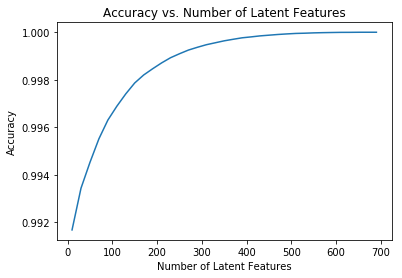

In [75]:
# Compute prediction error and plot accuracy vs. number of latent features
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - (np.array(sum_errs))/(user_item_matrix.shape[0]*user_item_matrix.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [76]:
# Shape of df
df.shape

(45993, 3)

In [77]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [78]:
# Shape of user_item_train matrix
user_item_train.shape

(4487, 714)

In [79]:
# Shape of user_item_test matrix
user_item_test.shape

(682, 574)

In [80]:
# Find number of users which are common to both the training and testing dataframe
len(set(user_item_train.index.tolist()).intersection(set(user_item_test.index.tolist())))

20

In [81]:
# Find number of articles which are common to both the training and testing dataframe
len(set(user_item_train.columns.tolist()).intersection(set(user_item_test.columns.tolist())))

574

In [82]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [83]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [84]:
# Find shape of u_train, s_train & vt_train matrix
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [85]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# Find users which are common to both the training and testing dataframe
user_common = np.array(list(set(user_item_train.index.tolist()).intersection(set(user_item_test.index.tolist()))))
print('20 user_ids common to both training & testing dataframe are :\n{}'.format(user_common))

# Get index of these 20 user_id's in matrix u_train
print('\nindex of these 20 user_ids in the u_train matrix are : \n{}'.format(user_common - 1))

20 user_ids common to both training & testing dataframe are :
[3968 3777 4002 3684 4293 2917 4487 4231 3527 4204 3532 3024 4274 3801 3093
 3989 3990 3193 3740 3998]

index of these 20 user_ids in the u_train matrix are : 
[3967 3776 4001 3683 4292 2916 4486 4230 3526 4203 3531 3023 4273 3800 3092
 3988 3989 3192 3739 3997]


In [86]:
# Get u_train matrix only for 20 common users
u_train_common = u_train[user_common - 1, :]

In [87]:
# Get shape of u_train matrix only for 20 common users
u_train_common.shape

(20, 4487)

In [88]:
# Find articles which are common to both the training and testing dataframe
article_common = list(set(user_item_train.columns.tolist()).intersection(set(user_item_test.columns.tolist())))
#print('article_ids common to both training & testing dataframe are :\n{}'.format(article_common))

# Get index of these common article_id's in matrix u_train
article_pos_u_train = [user_item_train.columns.tolist().index(ele) for ele in article_common]
#print('\nindex of these common article_ids in the u_train matrix are : \n{}'.format(article_pos_u_train))

In [89]:
# Get vt_train matrix only for common articles
vt_train_common = vt_train[:, article_pos_u_train]

In [90]:
# Get shape of vt_train matrix for common articles
vt_train_common.shape

(714, 574)

In [91]:
# Get 20 common users in user_item_test dataframe
user_item_test_common = user_item_test.loc[user_common,:]

In [92]:
# Get shape of user_item_test_common
user_item_test_common.shape

(20, 574)

In [93]:
# Get shapes of u_train_common, s_train & vt_train_common matrix
print(u_train_common.shape, s_train.shape, vt_train_common.shape)

(20, 4487) (714,) (714, 574)


In [94]:
#make predictions based on training set SVD for the overlapping 20 users that are also in the test set
#compare these predictions with the actual test matrix to get the test error for 20 common users
# Also, make predictions for the entire training set
# Compare the predictions with the original values in the training set to get the training error for the entire training set
# Also, compute the f1-score of the training data as well as for the common test data

num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test_common = []
f1_train = []
f1_test_common = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_train_common_new, u_train_common_new, vt_train_common_new = np.diag(s_train[:k]), u_train_common[:, :k],\
                                                                    vt_train_common[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_common_est = np.around(np.dot(np.dot(u_train_common_new, s_train_common_new), vt_train_common_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test_common = np.subtract(user_item_test_common, user_item_test_common_est)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    
    err_test_common = np.sum(np.sum(np.abs(diffs_test_common)))
    sum_errs_test_common.append(err_test_common)
    
    # compute f1 score (macro) for each prediction to actual value
    f1_train.append(f1_score(np.array(user_item_train).flatten(),\
                             user_item_train_est.flatten(), labels=[1.0], average='macro'))
    f1_test_common.append(f1_score(np.array(user_item_test_common).flatten(),\
                                   user_item_test_common_est.flatten(), labels=[1.0], average='macro'))

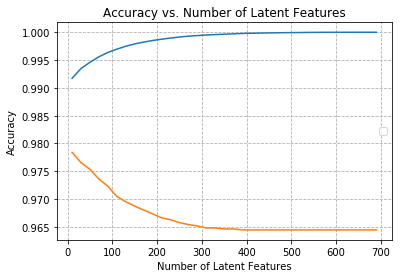

In [95]:
# Plotting Accuracy vs. Number of Latent features for both training data as well as for common test data which can be found in
# training data also
fig1, ax1 = plt.subplots()

ax1.plot(num_latent_feats, 1 - (np.array(sum_errs_train))/(user_item_train.shape[0]*user_item_train.shape[1]), label='Train')
ax1.plot(num_latent_feats, 1 - (np.array(sum_errs_test_common))/(user_item_test_common.shape[0]*\
                                                                 user_item_test_common.shape[1]), label='Test')

handler, label = ax.get_legend_handles_labels()

ax1.legend(handler, label, loc='center right')
ax1.grid(linestyle='--')
ax1.set_title('Accuracy vs. Number of Latent Features')
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Accuracy')

plt.show()

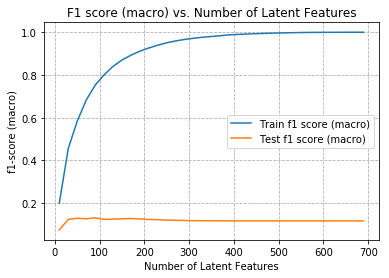

In [96]:
# Plotting f1-score vs. Number of Latent features for both training data as well as for common test data which can be found in
# training data also
fig2, ax2 = plt.subplots()

ax2.plot(num_latent_feats, f1_train, label='Train f1 score (macro)')
ax2.plot(num_latent_feats, f1_test_common, label='Test f1 score (macro)')

handler, label = ax2.get_legend_handles_labels()

ax2.legend(handler, label, loc='center right')
ax2.grid(linestyle='--')
ax2.set_title('F1 score (macro) vs. Number of Latent Features')
ax2.set_xlabel('Number of Latent Features')
ax2.set_ylabel('f1-score (macro)')

plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**1. From the above Accuracy plot, we can observe that the test accuracy(learning) curve is inverse of the training accuracy curve. The explanation for this is that increasing latent features caused overfitting during training. This meant that even though our model performs better on the training set it does not generalize well to predict testing data. Based on this I would try to keep fewer latent features. Since there were only 20 individuals who co-existed between the training and testing datasets, there isn't exactly a lot data that can be used to test how well predictions via collaborative filtering with SVD are matching up with actual values. Though the above plot for accuracy makes it look like we are doing great in terms of accuracy, this is largely due to the class imbalance of 1's and 0's. The model accuracy could be this high because this is mostly a sparse matrix, therefore we might not need to use very many latent features to correctly reproduce the original matrix. Also, What we could do, is to shuffle the data more by shuffle splitting the training and testing set, so that we could train on a more diversified set of data which could generalize while predicting values for the testing set.**

**2. In this situation, the accuracy is not appropriate, because predicted interactions between users and articles are very few (imbalanced). Test f1 score increased until a number of latent features were about 20, after that, it decreased with increased number of latent features. So, there is over-fitting when number of latent features got more than 20. Test f1 score is very low and the best number of latent feature as per f1-score curve appears to be about 20.**

**3. I would not yet implement a recommendation system solely using SVD as the training and testing sample is still quite small. Since we only have overlap of a few users and some articels between training and testing set, the SVD recommendations does not work well in this case. Nevertheless, this approach showed the benefits and possibility of training and testing sets even with recommendation systems. The same training and testing methodology could apply across the other recommendation methods (collaborative filtering, content based etc).**

**4. As an alternative to the offline approach we used here, we could do an online approach where we could run an A/B experiment to determine the impacts of implementing one or more recommendation systems into our user base. A simple A/B experiment for this situation might be to randomly assign half of users to a control group that receives no recommendations. A second group randomly receives recommendations using a mix of the methods provided above.** 

**5. For this, we could split the users by cookie based diversion, so that an equal number of users are split between A and B groups. This would be the invariant metric.**

**6. The evaluation metrics for this scenario could be like(the mean/median number of interactions by users in each group, rate of clicks on the recommended articles from the recommendation section, time spent on article after click through, rate of users that read/scroll to the end of the article).**

**7. We could then perform a hypothesis test where the null is that there is no difference in number of interactions against an alternative that there is a difference (or that the recommendation system increases the number of user-article interactions).**

**8. We could then use some reasonable alpha level to check each evaluation metric for statistical significance and to understand if the recommendation system increases user engagement. In that case, we can move forward using the results as a basis for using the recommendation system.**

In [159]:
# Create .html file or .pdf file of the notebook
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0